In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor

# Прогнозирование временных рядов с помощью алгоритма искусственных нейронных сетей

In [ ]:
GeneralDataFrame = pd.read_csv('AirPassengers.csv')
GeneralDataFrame.shape

In [ ]:
GeneralDataFrame.head()

In [ ]:
GeneralDataFrame.tail()

In [ ]:
GeneralDataFrame.describe()

На входе нашей задачи прогнозирования временного ряда мы имеем набор данных, в котором находятся данные по объему междунарожных авиаперевозок в США за период с января 1949г. по декабрь 1960г. Поставим задачу прогнозирования временного ряда на 1 месяц вперед, основываясь на данных которые мы имеем за 12 лет в месячной динамике, т.е всего 144 значения (скажем так, это не очень много, но в принципе жить с этим еще можно, это не временной ряд в месячной динамике за год или за два, в реальных задачах бизнеса и такое бывает).

Прежде чем приступать к разработке модели прогнозирования временного ряда, хотя бы графически оценим с каким временным рядом нам предстоит работать.

In [ ]:
#построим график имеющегося у нас временного ряда
plt.plot(GeneralDataFrame['#Passengers'])
plt.show()

Что мы уже можем сказать про этот временной ряд: есть возрастающий тренд, примерно линеный, есть мультипликативная сезонность, каких-то явных выбросов нет, ряд не меняет свой характер.

Что такое мультипликативная и аддитивная сезонности:

1. Если амплитуда колебаний меняется, мы говорим о мультипликативной сезонности. Тогда оценкой сезонности являются коэффициенты или %. Например, сезонность в январе 0,94%, это значит, что каждый январь систематически продажи составляют 94 % от уровня тенденции.
2. Если амплитуда сезонных колебаний не меняется, значить сезонность будет аддитивная. Оценкой сезонности будет абсолютная величина в единицах измерения продаж. Например, в январе сезонность «- 200 тыс. тонн» это значит отклонение (в данном случае - снижение) на 200 тыс.тонн по сравнению со средним уровнем.

Слева - пример мультипликативной сезонности, справа - пример аддитивной сезонности
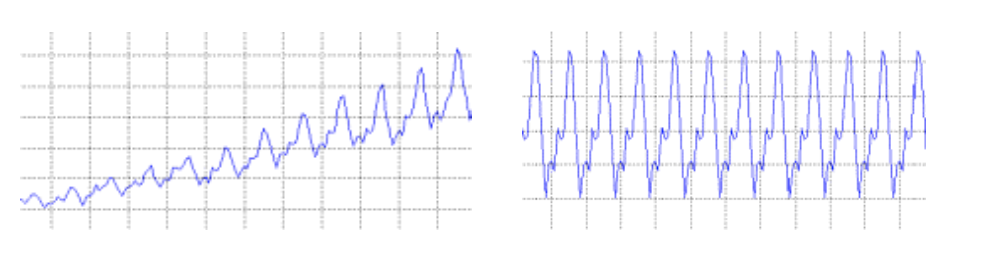

Из стуктуры данного временного ряда видно, что его структура повторяется каждые 12 месяцев и логически понятно, что для прогнозирования временного ряда на 1 значение вперед (на 1 месяц) достаточно значений за 12 предыдущих месяцев (за год), именно этого количества значений достаточно для учета всех сезонных поправок, не всегда конечно попадаюится временные ряды, где это сразу видно, и на самом деле определение количества предикторов для построения прогноза временного ряда - это отдельная аналитическая задача. Данный подход позволит нам перейти к классической регрессионной задаче: имеется 12 предикторов и 1 отклик, т.о с шагом в 1 месяц мы сможем пронозировать врменной ряд вперед. Для решения поставленной задачи, необходимо немного преобразовать набор данных, а именно сделать 12 независимых перменных - предикторов и 1 целевая переменная, которую будем прогнозировать.

In [ ]:
#напишем функцию для преобразования исходного набора данных в нужную нам форму для обучения нейронной сети
def TransformDataFrame(SourceData,Log):
    
    #предикторы
    x1 = []
    x2 = []
    x3 = []
    x4 = []
    x5 = []
    x6 = []
    x7 = []
    x8 = []
    x9 = []
    x10 = []
    x11 = []
    x12 = []
    #отклик 
    y = [] 
    
    for i in range(0,144):
        if i < 132:
            x1.append(SourceData[i])
        if ((i > 0) & (i < 133)):
            x2.append(SourceData[i])
        if ((i > 1) & (i < 134)):
            x3.append(SourceData[i])
        if ((i > 2) & (i < 135)):
            x4.append(SourceData[i])
        if ((i > 3) & (i < 136)):
            x5.append(SourceData[i])
        if ((i > 4) & (i < 137)):
            x6.append(SourceData[i])
        if ((i > 5) & (i < 138)):
            x7.append(SourceData[i])
        if ((i > 6) & (i < 139)):
            x8.append(SourceData[i])
        if ((i > 7) & (i < 140)):
            x9.append(SourceData[i])
        if ((i > 8) & (i < 141)):
            x10.append(SourceData[i])
        if ((i > 9) & (i < 142)):
            x11.append(SourceData[i])
        if ((i > 10) & (i < 143)):
            x12.append(SourceData[i])
        if ((i > 11) & (i < 144)):
            y.append(SourceData[i])
                        
    #соберем итоговый набор данных и сразу же прологарифмируем значения, чтобы привести ряд к стационарному виду 
    if Log == 'log':
        resultDF_data = {'x1':np.log(x1),'x2':np.log(x2),'x3':np.log(x3),'x4':np.log(x4),'x5':np.log(x5),
                         'x6':np.log(x6),'x7':np.log(x7),'x8':np.log(x8),'x9':np.log(x9),'x10':np.log(x10),
                         'x11':np.log(x11),'x12':np.log(x12),'y':np.log(y)}
        resultDf = pd.DataFrame(data = resultDF_data)
    elif Log == 'not_log':
        resultDF_data = {'x1':x1,'x2':x2,'x3':x3,'x4':x4,'x5':x5,
                         'x6':x6,'x7':x7,'x8':x8,'x9':x9,'x10':x10,
                         'x11':x11,'x12':x12,'y':y}
        resultDf = pd.DataFrame(data = resultDF_data)
    
    return resultDf

In [ ]:
ResultDF = TransformDataFrame(GeneralDataFrame['#Passengers'],'not_log')
ResultDF_log = TransformDataFrame(GeneralDataFrame['#Passengers'],'log')

In [ ]:
ResultDF

In [ ]:
ResultDF_log

Набор данных для обучения нейронной сети готов. Воспользовались логарифмированием, чтобы привести ряд к стационарному виду и выровнять дисперсию, ну и вообще из предыдущих занятий про предобработку данных мы знаем, что алгоритм искусственной нейронной сети как и алгоритм логистической регрессии чувствителен к ненормализованным данным, потому что является линейным алгоритмом, поэтому просто так подавать сырые данные на вход нейронной сети это не комильфо. После того как мы построим прогноз, нужно не забыть воспользоваться обратной логарифмированию операцией экспанирования.

Данные для обучения есть, они в нужном нам виде, предобработаны - нужно начинать обучать модельку, бизнес-менеджер, который поставил нам задачу ждать не будет, ему результаты нашей работы нужны были еще вчера.

При решении задачи прогнозирования временнх рядов исследователь может столкнуться с следующими проблемами:
1. Данных скорее всего будет не очень много и исследователь не сможет позволить себе такую роскошь как классическое деление на train и test выборки в какой-нибудь пропорции
2. При проведении валидации модели - использование классического подхода кросс-валидации в задаче прогнозирования временных рядов некорректный, по причине того, что при использованнии классического k-fold подхода не учитывается временная струтура ряда, а главная особенность временного ряда как раз в том и заключается, что в структуре времени есть очень много важной информации для построения прогноза, поэтому нужно использовать кросс-валидацию для временных рядов
3. Так или иначе наша модель будет работать где-нибудь на сервере в проде и она должна дооучаться на актуальных данных по мере их появления, т.е в нашем случае мы прогнозируем на месяц вперед, значит когда появятся новые фактические данные за месяц, необходимо дообучить нашу модель, чтобы учитывались самые актуальные особенности временного ряда, в этом нам тоже может помочь кроссвалидация для временных рядов 

Классический подход к проведению кросс-валидации:
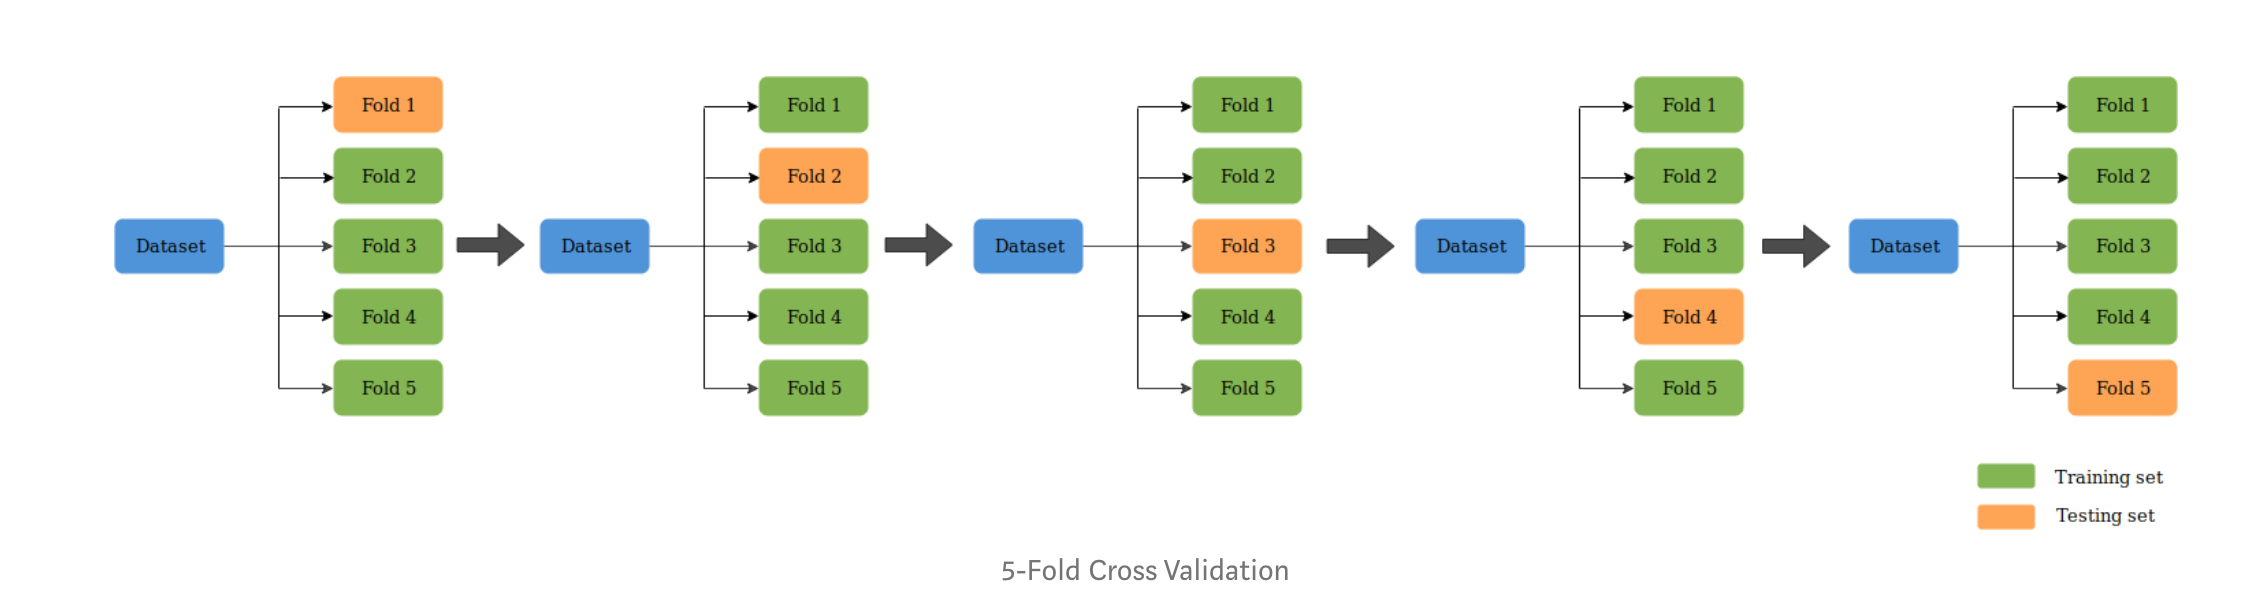

Как нужно делать кросс-валидацию (или лучше сказать последовательную валидацию) в задаче прогнозирования временных рядов:
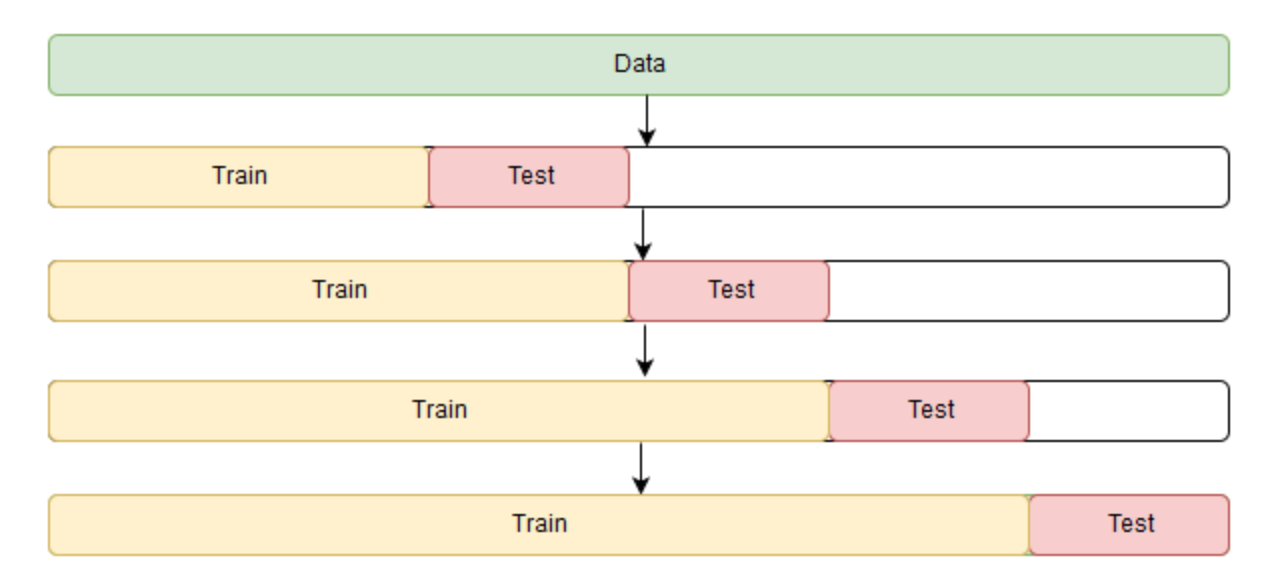

Собственно перейдем непосредственно к процессу работы с самой нейросетевой модели прогнозирования временного ряда. Вообще опытные люди в области прогнозирования временных рядов именно с помощью нейронных сетей говорят, что конкретно в этой задаче внутренняя архитектура нейронной сети (количество скрытыъ слоев и количество нейронов на каждом из них) на самый важный фактор успешного решения, гораздо важнее процесс предобработки и подоготовки данных (определение нужного количества предикторов для описания особенностей конкретного временного ряда, анализ основных стат.характеристик временного ряда и т.д и т.п).
У нас задача свелась к регрессионной задаче, а значит воспользуемся объектом нейронной сети для регрессии MLPRegressor. С полным перечнем его параметров можно ознакомиться на странице документации пакета sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html 

Конечно же нам необходима какая-то метрика, которая может нам понять насколько хорошо работает наша обученная модель. В большом количестве статей по прогнозированию временных рядов указается метрика MAPE (Mean Average Percentage Error) как наиболее подходящая для оценки точности работы моделей прогнозирования временных рядов.
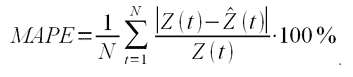
Дополнительная справочная информация по видам ошибок и когда какую применять: http://logist.ru/articles/oshibka-prognozirovaniya-kak-rasschitat-i-primenyat

In [ ]:
MLP = MLPRegressor(hidden_layer_sizes = (20,10),max_iter = 1000,random_state = 40)

In [ ]:
errors = []
predictions = []

#проведем 5 тестов последовательной валидации
for i in range(0,5):
    
    #на каждой итерации подготавливаем новый отренировочный набор данных и новый тестовый кортеж
    train_x = ResultDF_log.iloc[0:(127+i),0:12]
    train_y = ResultDF_log.iloc[0:(127+i),12]
    test_x = [ResultDF_log.iloc[(127+i),0:12]]
    test_y = [ResultDF_log.iloc[(127+i),12]]
    
    #последовательно обучаем нейронную сеть и последовательно тестируем на кортежах
    MLP.fit(train_x,train_y)
    pred = np.exp(MLP.predict(test_x))
    predictions.append(pred)
    error = (np.absolute(np.exp(test_y)-pred)/np.exp(test_y))*100
    errors.append(error)

#расчитаем ошибку MAPE для всего процесса последовательной валидации
MAPE = np.mean(errors)
Accuracy = 100 - MAPE
print('MAPE: ' + str(MAPE))
print('Accuracy: ' + str(Accuracy))

Модель нашу последовательно провалидировали на 5 экспериментах, тоность не сказать что высокая, но для первой итерации этого вполне достаточно, далее обучим нашу модель на полном наборе данных и построим прогноз на месяц вперед.

In [ ]:
#разделяем полный набор данных на предикторы и целевую переменную, обучаем нейронную сеть
XTrain = ResultDF_log.iloc[:,0:12]
YTrain = ResultDF_log.iloc[:,12]
MLP.fit(XTrain,YTrain)

In [ ]:
#для простроения прогноза на месяц вперед, возьмем 12 последних значений нашего временного ряда
Data = GeneralDataFrame['#Passengers']
FreshPredData = [np.log(Data.iloc[132:,])]
Pred = np.exp(MLP.predict(FreshPredData))
print(Pred)

To-do (по желанию): мы разработали нейросетевую модель прогнозирования временного ряда, но сделали это в попыхах и честно сказать - нам очень повезло с данными, которые у нас были для построения модели. Что можно еще сделать в плане анализа и в плане выкатывания такой модели на сервер в прод, чтобы она автоматически без нашего постоянного вмешательства дообучалась до нужной точности прогнозирования и работала практически автономно:
1. Проверка временного ряда на стационарность критерием Дики-Фуллера
2. Автоматически подбор гипер-параметров модели на дообучении до тех пор пока не достигнет нужной точности прогнозирования или не истечет количество попыток достичь этой точности